# Tarea 1: Diseño Avanzado de Algoritmos
## Uber
### Daniel San Martín

### Enunciado 

Uber es un sistema transporte que nos permite movilizarnos desde un punto de la ciudad a otro. Para esto, solicitamos el servicio de transporte poniéndonos en contacto con algún conductor, el cual va hacia donde estamos para llevarnos a donde deseamos, cumpliendo con la solicitud. Se presenta una ciudad que tiene 1.000 cuadras de oeste a este y 1.000 cuadras de sur a norte, donde todas las cuadras tienen igual largo. Los vehículos se puede desplazar por la ciudad a una velocidad de 1 [cuadra/unidad de tiempo].

La cantidad y posición de los ubers presentes en la ciudad está determinado por el horario: en la mañana hay 100 ubers, en la tarde 200 ubers y en la noche 50 ubers. Las solicitudes de los ubers van llegando cada ciertas unidades de tiempo de manera no uniforme. En cada horario se comienza a contar desde el tiempo 0, por ejemplo, en la mañana las solicitudes se comienzan a recibir desde el tiempo 0. Cada solicitud indica la coordenada de origen, la coordenada de destino y el tiempo en que ésta llega.

Implemente tres algoritmos para cumplir todas las solicitudes dadas

1. El primer algoritmo debe resolver las solicitudes de forma greedy.
2. El segundo algoritmo debe resolver las peticiones de manera aleatoria.
3. El tercer algoritmo debe resolver las solicitudes mediante el algoritmo Harmonic visto en clases.

La idea es que los Uber recorran la mínima distancia total, considerando las distancias de los trayectos que estos deben recorrer, es decir, la distancia donde se encuentre el Uber hacia donde se le esté solicitando y la distancia del origen de la solicitud hasta donde se tenga que llegar. Tenga en cuenta que para este caso, debe utilizar la distancia de Manhattan.

In [1]:
# Python version 3.7.2
import numpy as np # NumPy version 1.16.2
import matplotlib.pyplot as plt # Matplotlib version 3.0.2
import scipy.spatial.distance as sp_dist # SciPy version 1.2.1
#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning) 
np.random.seed(666)

In [2]:
DIR = "data/" # Base directory with ubers and requests

#### Distancia de Manhattan

La distancia de Manhattan, también conocida como distancia $L^1$, norma $\ell_1$ o geometría del taxista, se define formalmente como:

\begin{equation}
    d_1(\mathbf{p}, \mathbf{q}) = ||\mathbf{p}  - \mathbf{q}|| = \sum_{i=1}^n |p_i - q_i|,
\end{equation}

donde $\mathbf{p}=(p_1,p_2,...,p_n)$ y $\mathbf{q}=(q_1,q_2,...,q_n)$ son vectores. 

Para este caso particular, los vectores pertenecen a un plano por lo que $\mathbf{p}=(p_1,p_2)$, $\mathbf{q}=(q_1,q_2)$ y entonces $d_1(\mathbf{p},\mathbf{q})=|p_1-q_1|+|q_1-q_2|$. Un ejemplo de la diferencia con la distancia euclideana se presenta en la Figura 1.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/08/Manhattan_distance.svg">
<center><em>Figura 1.</em> Las líneas de color rojo, azul y amarillo corresponden a las posibles rutas más cortas entre dos puntos, utilizando la distancia de Manhattan como medida. Imagen obtenida de https://commons.wikimedia.org/wiki/File:Manhattan_distance.svg.</center>

Para simplificar el uso en el código posterior, se implementan 3 versiones distintas para cualcular la distancia de Manhattan. La primera versión se utiliza para comparar dos puntos, la segunda para calcular vectores con $n$ puntos y la última calcula la matriz de distancia entre los uber disponibles y los *requests* correspondientes.

In [3]:
# Manhattan distance
d  = lambda p1, p2: np.linalg.norm(p1 - p2, ord=1) # Compare two points
dv = lambda v1, v2: np.sum(np.abs(v1-v2), axis=1) #  Elementwise distance
dM = lambda v1, v2: sp_dist.cdist(v1, v2, metric='cityblock') # Distance matrix 

#### Funciones para cargar y guardar archivos

Las siguientes funciones se utilizan para cargar las peticiones y guardar los archivos de salida solicitados. Para optimizar algunos cálculos, los datos se guardan en arreglos de *NumPy*.

In [4]:
def loadRequest(request):
    data = []
    file = open(request)
    for line in file:
        data.append(list(map(int, line.strip().replace("-", " ").split())))
    file.close()
    return np.array(data)

In [5]:
def saveOutput(costs, filename):
    output = np.zeros((len(costs), 2), dtype=int)
    output[:,0] = np.arange(len(costs))
    output[:,1] = costs
    np.savetxt(filename, output, delimiter=" ", fmt='%i')

#### Función para graficar costos

La función para graficar costos se implementa de forma que se pueda comparar un archivo de *ubers* con cada archivo de *petición*.

In [69]:
def plotCosts(greedy, random, harmonic, req):
    f, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
    for i in range(len(axs)):
        axs[i].plot(np.arange(len(greedy[i])), greedy[i], label="Greedy")
        axs[i].plot(np.arange(len(random[i])), random[i], label="Random")
        axs[i].plot(np.arange(len(harmonic[i])), harmonic[i], label="Harmonic")
        axs[i].set_xlabel("Time")
        axs[i].legend()
        axs[i].grid(True)
    axs[0].set_ylabel("Cost")
    axs[0].set_title("Request " + str(req) + ": Mañana")
    axs[1].set_title("Request " + str(req) + ": Tarde")
    axs[2].set_title("Request " + str(req) + ": Noche")
    plt.tight_layout()
    plt.show()

#### Carga de datos

Dada la estructura de los archivos entregados, los datos se manipulan de la siguiente forma:

* Posiciones de los Ubers: Arreglo *NumPy* de $n\times2$, como se detalla a continuación.

|Uber    |$x$     |$y$     |
|--------|--------|--------|
| 1      |$x_1$   |$y_1$   |
| 2      |$x_2$   |$y_2$   |
|$\vdots$|$\vdots$|$\vdots$|
|$n$     |$x_n$   |$y_n$   |

* Peticiones: Arreglo *NumPy* de $m\times5$, como se detalla a continuación.

|Petición|$x_i$      |$y_i$      |$x_f$      |$y_f$      | $t$    |
|--------|-----------|-----------|-----------|-----------|--------|
| 1      |$x_{i_{1}}$|$y_{i_{1}}$|$x_{f_{1}}$|$y_{f_{1}}$|$t_1$   |
| 2      |$x_{i_{2}}$|$y_{i_{2}}$|$x_{f_{2}}$|$y_{f_{2}}$|$t_2$   |
|$\vdots$|$\vdots$   |$\vdots$   |$\vdots$   |$\vdots$   |$\vdots$|
|$m$     |$x_{i_{m}}$|$y_{i_{m}}$|$x_{f_{m}}$|$y_{f_{m}}$|$t_m$   |


In [8]:
# Load positions
manana = np.loadtxt(DIR + 'manana.dat', dtype=int)
tarde = np.loadtxt(DIR + 'tarde.dat', dtype=int)
noche = np.loadtxt(DIR + 'noche.dat', dtype=int)

Dado que la estructura de ubers es más simple, solo se utiliza la función ```np.loadtxt()```de *NumPy* para leer el archivo.

In [9]:
# Load requests
req_1 = loadRequest(DIR + 'requests_1.dat')
req_2 = loadRequest(DIR + 'requests_2.dat')
req_3 = loadRequest(DIR + 'requests_3.dat')

#### Algoritmo Base

El algoritmo base para la solución del problema se basa en manejar 3 estructuras. Estas son:
1. Las peticiones para el tiempo $t$. La estructura peticiones es un arreglo *NumPy* que denotaremos como $r_t$.
2. Los ubers disponibles para atender las peticiones, se denotan como $A$ y corresponde a un arreglo de *NumPy* que guarda las posiciones $(x,y)$ donde se encuentra el vehículo.
3. Los ubers que están atendiendo una petición, $B$, que será un arreglo *NumPy* que guarda $(x,y)$, la posición final en la cual estará el vehículo al finalizar su servicio y $c$ el costo asociado a la distancia de viaje.

El costo se calcula como el número de Ubers en servicio o $B$.

Luego, el algoritmo general hace lo siguiente.

* Para cada ventana de tiempo $t$.
    1. A todos los elementos de $B$, le quitamos 1 al costo asociado al servicio.
    2. Si existen ubers en $B$ en los cuales sus costos sean 0, entonces:
        1. Los agregamos a $A$, y los quitamos de $B$.
    3. Si no hay ubers en $A$, pasamos las peticiones de $r_t$ a $r_{t+1}$.
    4. Si hay ubers en $A$, obtenemos las peticiones $r_t$. 
    5. Si hay elementos en $r_t$:
        1. Obtenemos las distancias, los autos que atenderán las peticiones y las peticiones que serán atendidas. Esto se obtendrá según los tres criterios solicitados, *Greedy, Aleatorio y Harmonic*.
        2. Quitamos los autos que ya no estarán disponibles,
        3. Pasamos las peticiones no atendidas a la próxima ventana de tiempo,
        4. Calculamos los costos del viaje,
        5. Agregamos los ubers que están atendiendo una petición.
    6. Calculamos la función de costo sumando el costo de $t-1$ más el número de autos en servicio para el tiempo $t$.

In [10]:
def base(uber, request, func):
    T = 12001
    A = np.copy(uber) # Candidates
    B = [] # Ubers in service
    R = np.copy(request) # Requests
    r_t = [] # Request to process in time t
    costs = np.zeros(T) # Array to save costs
    
    for t in range(T): # Time windows
        
        # If there are ubers in service
        if len(B) > 0:
            B[:,-1] -= 1 # Remove 1 from cost (it simulates the car moving to end of request destination)
            pos_serv = np.where(B[:,2] <= 0)[0] # Get array position of ubers in destination

            if len(B[pos_serv]) > 0: # If there are ubers that complete the service
                A = np.vstack((A, B[pos_serv, :2])) # Add to candidates array
                B = np.delete(B, pos_serv, axis=0) # Remove from ubers in service
        
        if len(A) == 0: # If there is no uber available
            R[pos,4] += 1 # Pass requests from t to next time (t+1) 
        else:
            # Get positions of requests at time t
            pos = np.where(R[:,4] == t)[0] 
            r_t = R[pos,:4] # Copy initial and final positions of requests at time t
        
            # If there are requests
            if len(r_t) > 0:

                # Get distance, candidates and selected request positions using func criteria
                dist, cand_pos, req_pos_at = func(A, r_t[:,:2])

                # Remove uber from candidates
                A = np.delete(A, cand_pos, axis=0) 
                
                # If selected requests are less than total request at time t
                if len(req_pos_at) < len(r_t):
                    req_pos = np.arange(len(r_t))
                    next_t = np.delete(req_pos, req_pos_at)
                    R[pos[next_t], :4] += 1 # Pass request not attended to t+1

                # Compute costs
                # cost of go to request position
                atte_cost = dist.reshape(-1, 1) 
                # Cost of go from initial to final position
                serv_cost = dv(r_t[req_pos_at,:2], r_t[req_pos_at,2:4]).reshape(-1, 1)
                
                # Create array with [x_f, y_f, cost] for the uber in service
                tmp = r_t[req_pos_at, 2:4] # The new position of uber at end of service
                tmp = np.hstack((tmp, atte_cost + serv_cost))

                # Add uber to service
                if len(B) == 0: # New serv array
                    B = tmp
                else: # Append if there are ubers in service
                    B = np.vstack((B, tmp))

        
        # Cost function. Number of uber in service
        costs[t] = len(B) + costs[t-1]  # (at t-1 in t=0, just get 0 from numpy cost with zeros)
        
    return costs

#### Algoritmo Greedy

El algoritmo Greedy buscará el par uber-petición con menor distancia, es decir, los "óptimos" en cada tiempo. De forma general se pueden definir los siguientes pasos:

1. Calcular la matriz de distancias.
2. Para cada petición buscamos el auto que minimiza el costo del viaje = costo de llegar al cliente + el costo de llevarlo a su destino. Si hay más peticiones que ubers, solo atendemos las que podamos con la cantidad de ubers disponibles.

In [11]:
def greedyFunc(cand, req):
    # Compute distance matrix, cars in rows and requests in columns
    dist = dM(cand, req) 
    # If there are more request than available cars, we only get the max number of cars to service
    n = len(cand) if len(req) > len(cand) else len(req) 
    # Arrays for selected cars and requests
    sel_car = np.zeros(n, dtype=int)
    sel_req = np.zeros(n, dtype=int)
    dist_tmp = np.copy(dist) # Temporal distance matrix
    # For each request
    for k in range(n):
        # Search position (i,j) of min distance
        i, j = np.unravel_index(dist_tmp.argmin(), dist_tmp.shape) 
        sel_car[k] = i # Selected car
        sel_req[k] = j # Selected request
        # Replace row i and columns j with inf to ommit the car and request in next iteration
        dist_tmp[i] = np.full_like(dist_tmp[i], np.inf) 
        dist_tmp[:,j] = np.full_like(dist_tmp[:,j], np.inf)
    
    return dist[sel_car, sel_req], sel_car, sel_req # Return distance, selected ubers and requests

#### Algoritmo aleatorio

El algoritmo aleatorio atiende una petición aleatoria con un uber aleatorio sin importar la distancia de la solicitud. Esto es: atiende cualquier solicitud con cualquier vehículo.

In [12]:
def randomFunc(cand, req):
    # Get random ubers for requests
    n = len(cand) if len(req) > len(cand) else len(req) # If there are more requests than candidates
    rand_pos = np.random.choice(len(cand), n, replace=False) # Random ubers
    rand_req = np.random.choice(len(req), n, replace=False) # Random requests
    dist = dv(cand[rand_pos], req[rand_req]) # Compute distance between selected ubers and requests
    return dist, rand_pos, rand_req # Return distance, selected ubers and requests

#### Algoritmo *Harmonic*

Este algoritmo utiliza un criterio aleatorizado para decidir cual uber enviará a cada petición. Esto lo realizada utilizando los pesos definidos como:

\begin{equation}
    \vec{w}_i^{k} = \frac{\frac{1}{d_1(a_k, r_i)}}{\sum_{a\in A}\frac{1}{d_1(a,r_i)}}, 
\end{equation}

con $0\leq w_i^{k} <1$ y $\sum_{k}w_{i}^k = 1$. Luego los pasos generales son:

1. Calcular la matriz de distancias.
2. Calcular los pesos con la fórmula descrita anteriormente.
3. Para cada petición elegir un auto de forma aleatoria (sin reposición) utilizando los pesos $\vec{w}_i^{k}$. Si la cantidad de peticiones es mayor que la cantidad de ubers disponibles, solo se consideran las que se puedan atender según la disponibilidad de autos.

In [25]:
def harmonicFunc(cand, req):
    # Distance matrix between ubers and requests 
    dist = dM(req, cand) # Request in rows and ubers in columns to emulate the table in class notes

    # Compute weights
    dist[dist == 0] = 1e-12 # Avoid distances equal to 0
    M = 1/dist 
    M[np.isnan(M)] = 1 # Set 1/0 with 1 (if there are number close to zero)
    M[np.isinf(M)] = 1
    n = np.sum(1/dist, axis=1)
    nr = np.repeat(n.reshape(-1,1), len(cand), axis=1) 
    w = M / nr
    
    # Select ubers using weights 
    n = len(cand) if len(req) > len(cand) else len(req) # If there are more requests than candidates
    har_pos = np.full(n, -1, dtype=int) # To keep cars selected
    
    # For each request
    for i in range(n):
        # Choose random car with probability computed above
        if np.sum(w[i]) == 0: rand_ = np.random.choice(len(cand), 1, replace=False)[0]
        else: rand_ = np.random.choice(len(cand), 1, p=w[i], replace=False)[0]
        # This avoid to select the same car 
        while rand_ in har_pos: rand_ = np.random.choice(len(cand), 1, p=w[i], replace=False)[0]
        har_pos[i] = rand_
        
    dist = dv(cand[har_pos], req[:n]) # Compute distance between selected ubers and requests
    return dist, har_pos, np.arange(n) # Return distance, selected ubers and requests

Definimos los algoritmos utilizando la función base y el criterio correspondiente.

In [14]:
def greedy(uber, request):
    return base(uber, request, greedyFunc)

In [15]:
def random(uber, request):
    return base(uber, request, randomFunc)

In [16]:
def harmonic(uber, request):
    return base(uber, request, harmonicFunc)

<!-- ## Ubers positions at $t=0$ -->

#### Experimentos

In [17]:
reqs = [req_1, req_2, req_3]

In [18]:
ubers = [manana, tarde, noche]

In [19]:
#c= greedy(manana, req_3)

In [20]:
#plt.plot(np.arange(len(c)), c)
#np.max(c)

Para los algoritmos que contienen componentes aleatorios, se realizarán 10 experimentos y se reportará el promedio para cada $t$.

In [21]:
ub_label = ["Mañana", "Tarde", "Noche"] # For log...

# To save experiments
gree = []
rand = []
harm = []

# For random algorithms
n_exps = 10
exps = np.zeros((2 * n_exps, 12001))

# Compute experiments
for r in range(len(reqs)):
    for u in range(len(ubers)):
        print("Calculando %s - Request %d" % (ub_label[u], r+1))
        print("Greedy...")
        gree.append(greedy(ubers[u], reqs[r]))
        # Experiments for random alg
        for e in range(n_exps):
            print("Random " + str(e + 1) + "...")
            exps[e] = random(ubers[u], reqs[r])
            print("Harmonic " + str(e + 1) + "...")
            exps[e+n_exps] = harmonic(ubers[u], reqs[r])
        # Compute mean
        rand.append(np.mean(exps[:n_exps], axis=0))
        harm.append(np.mean(exps[n_exps:], axis=0))

Calculando Mañana - Request 1
Greedy...
Random 1...
Harmonic 1...
Random 2...
Harmonic 2...
Random 3...
Harmonic 3...
Random 4...
Harmonic 4...
Random 5...
Harmonic 5...
Random 6...
Harmonic 6...
Random 7...
Harmonic 7...
Random 8...
Harmonic 8...
Random 9...
Harmonic 9...
Random 10...
Harmonic 10...
Calculando Tarde - Request 1
Greedy...
Random 1...
Harmonic 1...
Random 2...
Harmonic 2...
Random 3...
Harmonic 3...
Random 4...
Harmonic 4...
Random 5...
Harmonic 5...
Random 6...
Harmonic 6...
Random 7...
Harmonic 7...
Random 8...
Harmonic 8...
Random 9...
Harmonic 9...
Random 10...
Harmonic 10...
Calculando Noche - Request 1
Greedy...
Random 1...
Harmonic 1...
Random 2...
Harmonic 2...
Random 3...
Harmonic 3...
Random 4...
Harmonic 4...
Random 5...
Harmonic 5...
Random 6...
Harmonic 6...
Random 7...
Harmonic 7...
Random 8...
Harmonic 8...
Random 9...
Harmonic 9...
Random 10...
Harmonic 10...
Calculando Mañana - Request 2
Greedy...
Random 1...
Harmonic 1...
Random 2...
Harmonic 2...
Rand

#### Guardar Archivos



In [ ]:
alg_l = ['greedy', 'random', 'harmonic']
ub_l = ['man', 'tar', 'noc']

for r in range(3):
    for h in range(3):
        saveOutput(gree[3*r+h], 'req-' + str(r+1) + "_" + ub_l[h] + "_greedy.dat")
        saveOutput(rand[3*r+h], 'req-' + str(r+1) + "_" + ub_l[h] + "_random.dat")
        saveOutput(harm[3*r+h], 'req-' + str(r+1) + "_" + ub_l[h] + "_harmonic.dat")

#### Comparación de Rendimientos

Para analizar el comportamiento de los algoritmos, se utilizarán dos criterios: 1) comparar los costos finales de cada algoritmo; 2) realizar un análisis de las curvas.

### Costos para el request 1

In [71]:
print("Costos Finales Request 1")
print("* Mañana: ")
print("Greedy:", gree[0][-1])
print("Random:", rand[0][-1])
print("Harmonic:", harm[0][-1])
print("* Tarde: ")
print("Greedy:", gree[1][-1])
print("Random:", rand[1][-1])
print("Harmonic:", harm[1][-1])
print("* Noche: ")
print("Greedy:", gree[2][-1])
print("Random:",rand[2][-1])
print("Harmonic:", harm[2][-1])

Costos Finales Request 1
* Mañana: 
Greedy: 372619.0
Random: 652880.2
Harmonic: 554690.1
* Tarde: 
Greedy: 353567.0
Random: 658829.3
Harmonic: 547851.4
* Noche: 
Greedy: 445836.0
Random: 500267.2
Harmonic: 492335.9


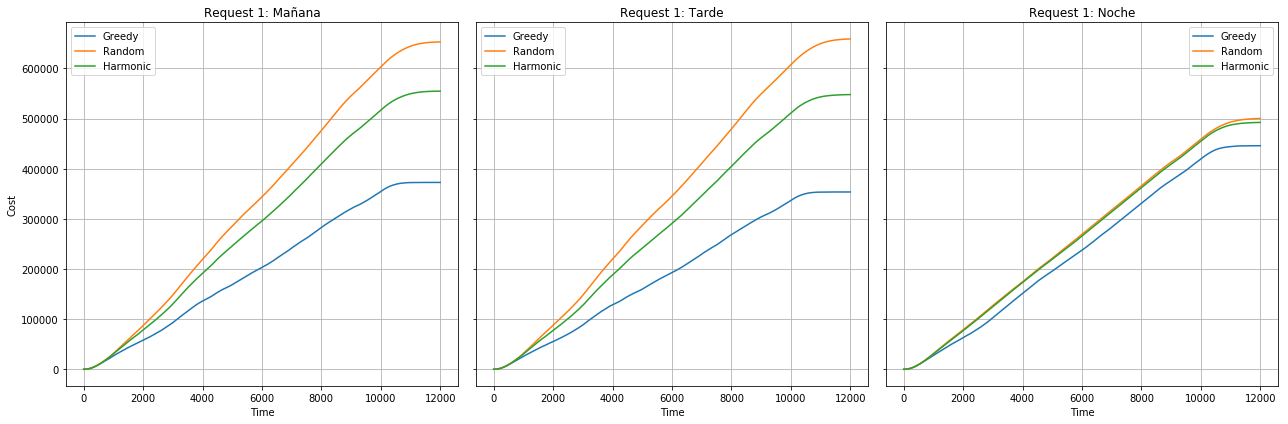

In [72]:
plotCosts(gree[:3], rand[:3], harm[:3], 1)

Los costos son similares en la mañana y tarde, pero en la noche vemos un comportamiento distinto en las curvas. Notamos que en este último caso, las curvas del algoritmo *Harmonic* y *Aleatorio* están muy cercanos y se diferencian en aproximadamente $50000$ unidades de costo del algoritmo *Greedy*. Comparando los costos finales, vemos que para los 3 casos el orden de rendimiento de menor a mayor costo es: *Greedy*, *Harmonic* y *Aleatorio*.

### Costos para el request 2

In [73]:
print("Costos Finales Request 2")
print("* Mañana: ")
print("Greedy:", gree[3][-1])
print("Random:", rand[3][-1])
print("Harmonic:", harm[3][-1])
print("* Tarde: ")
print("Greedy:", gree[4][-1])
print("Random:", rand[4][-1])
print("Harmonic:", harm[4][-1])
print("* Noche: ")
print("Greedy:", gree[5][-1])
print("Random:",rand[5][-1])
print("Harmonic:", harm[5][-1])

Costos Finales Request 2
* Mañana: 
Greedy: 365751.0
Random: 422906.2
Harmonic: 398039.0
* Tarde: 
Greedy: 366925.0
Random: 660421.7
Harmonic: 551789.5
* Noche: 
Greedy: 240902.0
Random: 287436.3
Harmonic: 266749.8


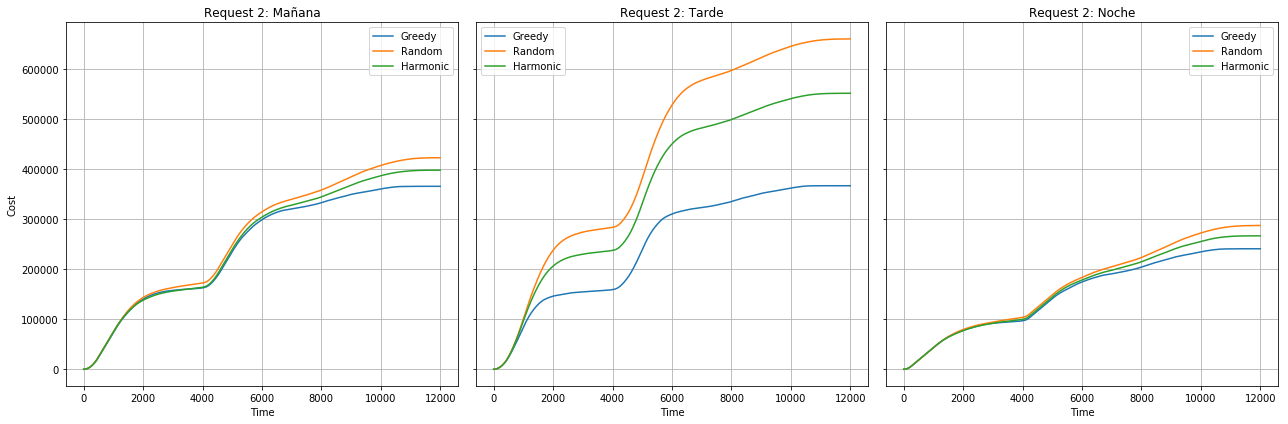

In [68]:
plotCosts(gree[3:6], rand[3:6], harm[3:6], 2)

Para estas peticiones, el comportamiento de los algoritmos para los Uber de mañana y noche es muy similar hasta el tiempo 6000 aproximadamente. Posterior a esto recién es posible notar como se separan las curvas. En el caso de la tarde se nota una mayor holgura entre curvas. Comparando los costos finales, vemos que para los 3 casos el orden de rendimiento de menor a mayor costo es: *Greedy*, *Harmonic* y *Aleatorio*.

### Costos para el request 3

In [74]:
print("Costos Finales Request 3")
print("* Mañana: ")
print("Greedy:", gree[6][-1])
print("Random:", rand[6][-1])
print("Harmonic:", harm[6][-1])
print("* Tarde: ")
print("Greedy:", gree[7][-1])
print("Random:", rand[7][-1])
print("Harmonic:", harm[7][-1])
print("* Noche: ")
print("Greedy:", gree[8][-1])
print("Random:",rand[8][-1])
print("Harmonic:", harm[8][-1])

Costos Finales Request 3
* Mañana: 
Greedy: 96519.0
Random: 170483.4
Harmonic: 143476.8
* Tarde: 
Greedy: 92403.0
Random: 206702.7
Harmonic: 161928.9
* Noche: 
Greedy: 101494.0
Random: 154886.1
Harmonic: 132563.2


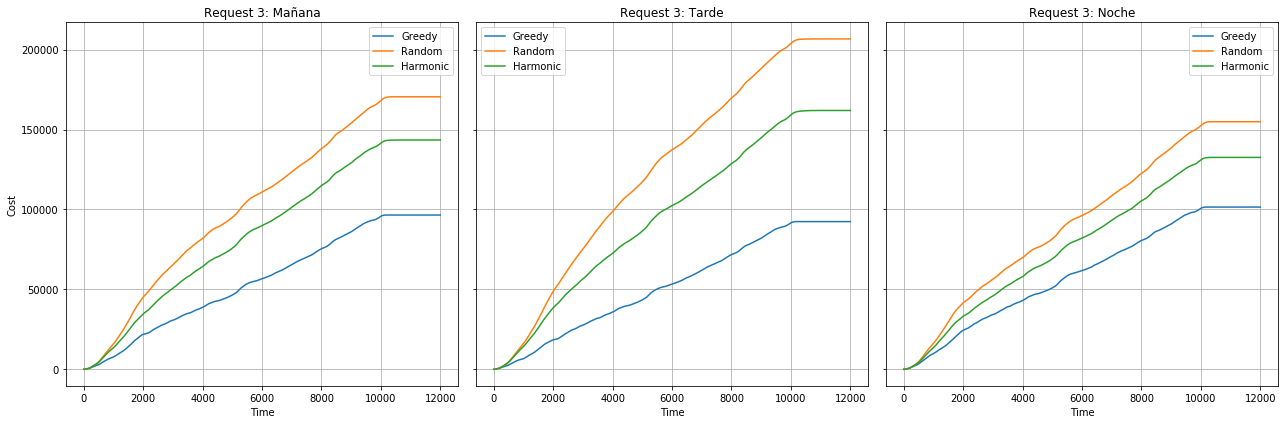

In [24]:
plotCosts(gree[6:], rand[6:], harm[6:], 3)

En este último caso las curvas muestran comportamientos levemente distintos para cada período del día, aunque gráficamente se nota que *Harmonic*, que está en el centro, se acerca más al algoritmo *Random* que al *Greedy*. Algo interesante que destacar es la función de costos del algoritmo *Greedy* que es similar en cada período del día. Los mayores costos para los algoritmos *Harmonic* y *Random* están en la tarde. Comparando los costos finales, vemos que para los 3 casos el orden de rendimiento de menor a mayor costo es: *Greedy*, *Harmonic* y *Aleatorio*.

### Conclusiones

En general, el comportamiento de algoritmos para las peticiones siguen el orden (de menor a mayor costo):

1. Greedy
2. Harmonic
3. Aleatorio

Esto de alguna forma se puede prever, dado que el algoritmo *Greedy* busca las distancias mínimas para las peticiones en cada tiempo $t$, por ende debería mantener los ubers ocupados por menos tiempo. Un enfoque completamente aleatorio, no toma en consideración las distancias, por lo que los ubers pueden tomar cualquier petición aun cuando un uber disponible esté al otro lado de la ciudad. El algoritmo *Harmonic* está justo al medio, puesto que combina un enfoque de óptimo local con aleatoriedad. 

Los mayores costos para cada algoritmo se encuentran en el período de la tarde y alguno de los factores involucrados en este comportamiento puede ser que los viajes recorran mayor distancia, que los uber estén mal ubicados al momento de ser solicitados o por la mayor disponibilidad de vehículos, permite mantener más vehículos en servicio. En el período de la noche, los algoritmos tuvieron un comportamiento similar (en general), pero para el archivo de *request 1* este comportamiento fue el de menor diferencia.